In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot

In [2]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os

#import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

def compute_spot_size(adata, gene_symbol, size):
    r""" returns a vector with the size of the spots. Areas where no expression is observed for a given
    gene are set to size zero.
    
    :param adata: Anndata object
    :param gene_symbol: Gene Symbol for whom we explore gene expression
    :param size: size for the spots when their expression is different from zero.
    """
    index=adata.var[adata.var["SYMBOL"]== gene_symbol].index.values[0]
    expression_values = adata.X.todense()[:,adata.var.index.get_loc(index)]
    for x in range(len(expression_values)):
        if expression_values[x] > 0:
            expression_values[x] = size
        else:
            expression_values[x] = 0
    
    
    return expression_values.tolist()

In [4]:
sp_data_file = './Spatial/DeconvolutionResults_ST_CRC_BelgianCohort/sp.h5ad'
adata_vis = anndata.read(sp_data_file)


In [5]:
import pandas as pd
Genes = pd.read_table('./ISGgene.txt', header = None)
gene_list = Genes[0].tolist()

# adata_visl Overview

In [6]:
slices = 'Count_SN84_A120838_Rep2'
slide = select_slide(adata_vis, slices)
sc.pp.normalize_total(slide, inplace=True)
sc.pp.log1p(slide)
len(slide)
#sc.pp.highly_variable_genes(slide, flavor="seurat", n_top_genes=2000)

1045

In [7]:
sc.tl.score_genes(slide, gene_list, score_name='ISG score', use_raw = False, n_bins=38)


In [8]:
PredictPor = slide.obs[[x for x in slide.obs.columns if 'q05_spot_factors' in x]].T/slide.obs[[x for x in slide.obs.columns if 'q05_spot_factors' in x]].sum(1)
PredictedCell = slide.obs[[x for x in slide.obs.columns if 'q05_spot_factors' in x]].columns
for celltype in PredictedCell:
    slide.obs[celltype] = PredictPor.T.loc[slide.obs.index, celltype]
slide.obs[[x for x in slide.obs.columns if 'q05_spot_factors' in x]].sum(1)

spot_id
Count_SN84_A120838_Rep2_AAACGAGACGGTTGAT-1    1.0
Count_SN84_A120838_Rep2_AAACTCGTGATATAAG-1    1.0
Count_SN84_A120838_Rep2_AAACTGCTGGCTCCAA-1    1.0
Count_SN84_A120838_Rep2_AAAGTGTGATTTATCT-1    1.0
Count_SN84_A120838_Rep2_AAAGTTGACTCCCGTA-1    1.0
                                             ... 
Count_SN84_A120838_Rep2_TTGTAAGGCCAGTTGG-1    1.0
Count_SN84_A120838_Rep2_TTGTGCAGCCACGTCA-1    1.0
Count_SN84_A120838_Rep2_TTGTGTATGCCACCAA-1    1.0
Count_SN84_A120838_Rep2_TTGTTCAGTGTGCTAC-1    1.0
Count_SN84_A120838_Rep2_TTGTTGTGTGTCAAGA-1    1.0
Length: 1045, dtype: float64

In [9]:
with mpl.rc_context({'figure.figsize': (6,6), "font.size": 10}):
    sc.pl.spatial(slide, color=['ENPP1', 'ENPP1', 'ENPP1', 'ENPP1'], size=1.25, color_map = "Reds", use_raw=False, alpha_img = 1, ncols=4, hspace=0.2, wspace=0.1, vmax = 0.8)

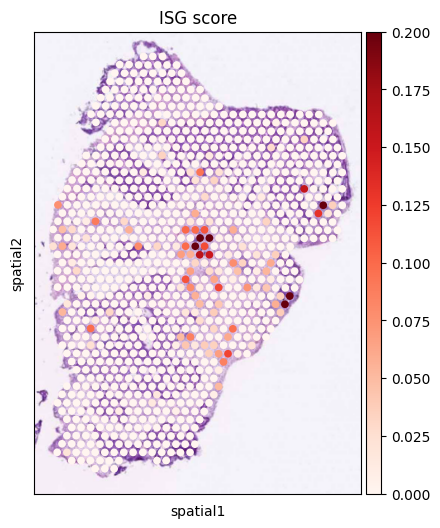

In [14]:
with mpl.rc_context({'figure.figsize': (6,6), "font.size": 10}):
    sc.pl.spatial(slide, color=['ISG score'], size=1.25, color_map = "Reds", use_raw=False, alpha_img = 1, vmax = 0.2, ncols=4, vmin = 0, hspace=0.2, wspace=0.1)

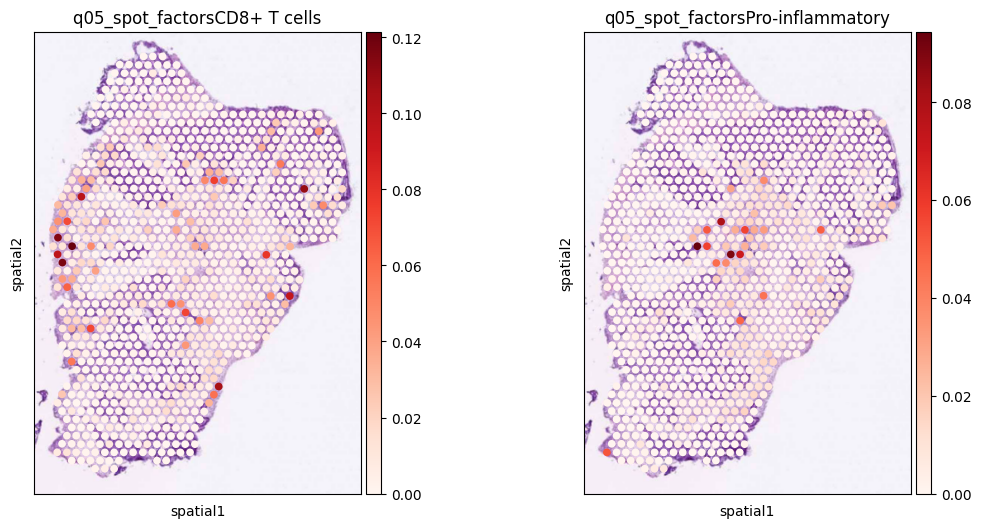

In [15]:
with mpl.rc_context({'figure.figsize': (6,6), "font.size": 10}):
    sc.pl.spatial(slide, color=['q05_spot_factorsCD8+ T cells', 'q05_spot_factorsPro-inflammatory'], size=1.25, color_map = "Reds", use_raw=False, alpha_img = 1, ncols=4, vmin = 0, hspace=0.2, wspace=0.1)